# Msc Project Code

## Preprocessing step

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Input, TimeDistributed, Flatten, Reshape, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

from scipy.stats import nbinom, poisson
from scipy.special import expit

import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= '5'

In [41]:
print(os.environ["CUDA_VISIBLE_DEVICES"])

5


In [39]:
import sys
print(sys.version)
print(tf.config.list_logical_devices('GPU'))

3.8.10 (default, Nov 26 2021, 20:14:08) 
[GCC 9.3.0]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [3]:
print('loading covid data')
df2 = pd.read_csv("ltla_2022-05-19.csv")

def tes_train(train_df, n_past, total_period):
    X_new = []
    y_new = []
    n_train = len(train_df)
    idx_start = n_train-total_period
    ylist = train_df
    while idx_start > 0:
        x_line = ylist[idx_start:idx_start+n_past]
        y_line = ylist[idx_start+n_past:idx_start+total_period]
        y_line = [[x[1] + x[13]] for x in y_line]
        x_line = [[x[0]] + x[2:13] + x[14:] for x in x_line]
        X_new.append(x_line)
        y_new.append(y_line)
        idx_start = idx_start - 1
    
    return X_new, y_new

print('processing lists')
areas = list(np.unique(df2.areaName))
ages = list(np.unique(df2.age))
ages_short = ['00_59', '60+']
ages = ages[:-1]

print('filter and reshape')
dftrain = df2[('2021-11-00' >= df2.date) & (df2.date >='2020-08-00')].pivot(index =['areaName', 'date'], columns = ['age'], values= 'cases')[ages]
dfval = df2[('2021-11-00' < df2.date)].pivot(index =['areaName', 'date'], columns = ['age'], values= 'cases')[ages]

dlent = int(len(dftrain)/len(areas))
dlenv = int(len(dfval)/len(areas))
dar = len(areas)
dcas = len(ages)

print('reshape pandas')

df3t = dftrain.to_numpy().reshape(dar, dlent, dcas).astype(float).tolist()
df3v = dfval.to_numpy().reshape(dar, dlenv, dcas).astype(float).tolist()

print('construct lists')

x_train_2 = []
y_train_2 = []
x_val_2 = []
y_val_2 = []
for train in df3t:
    x_train, y_train = tes_train(train, 14, 42)
    x_train_2 = x_train_2 + x_train
    y_train_2 = y_train_2 + y_train

for val in df3v:
    x_val, y_val = tes_train(val, 14, 42)
    x_val_2 = x_val_2 + x_val
    y_val_2 = y_val_2 + y_val

train_nb_2 = tf.data.Dataset.from_tensor_slices((x_train_2, y_train_2))
val_nb_2 = tf.data.Dataset.from_tensor_slices((x_val_2, y_val_2))

print('shuffle and batch')

train_ds_2 = train_nb_2.batch(128).shuffle(1000).unbatch().shuffle(1000).batch(1024).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_2 = val_nb_2.batch(64).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_2.element_spec

n_timesteps = train_ds_2.element_spec[0].shape[1]
n_features = train_ds_2.element_spec[0].shape[2]
n_future = train_ds_2.element_spec[1].shape[1]



loading covid data
processing lists
filter and reshape
reshape pandas
construct lists
shuffle and batch


In [4]:
print([dar,dlent,dcas])
print([dar,dlenv,dcas])
print(dlenv/(dlenv + dlent))

print([n_timesteps, n_features, n_future])



[315, 457, 21]
[315, 195, 21]
0.299079754601227
[14, 19, 28]


## Model Definitions step

In [4]:
imp = Input(shape=(n_timesteps, n_features))

g = tf.expand_dims(tf.math.reduce_sum(imp[..., -1, :], axis=-1, keepdims=True), axis=-1)

h = LSTM(128, activation='tanh', dropout=0.1, recurrent_dropout=0.1)(imp)
h = RepeatVector(14)(h)
h = LSTM(32, activation='tanh', return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(h)
h = LSTM(32, activation='tanh', return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(h)

h = TimeDistributed(Dense(16))(h)
h = Dropout(0.1)(h)
h = TimeDistributed(Dense(6))(h)

h = Reshape((28,3))(h)

h1 = tf.math.multiply(tf.math.exp(h[... ,: ,0:1 ]), tf.math.add(tf.ones((1)),g))
h2 = tf.math.add(tf.math.exp(h[... ,: ,1:2]), h1)
h3 = tf.math.sigmoid(h[... , :, 2:3])

p = tf.math.subtract(tf.ones((1)), tf.math.divide(h1,h2))
r = tf.math.divide(tf.math.add(tf.math.square(h1), h1), h2)
s = tf.math.divide(tf.math.multiply(h3,p),tf.math.add(tf.math.subtract(tf.ones((1)), tf.math.multiply(h3, p)), h3))

out = tfpl.DistributionLambda(make_distribution_fn=lambda t : tfd.NegativeBinomial(total_count=t[0], probs = t[1]))([r, s])

comp_model_1 = Model(inputs=imp, outputs=out)

In [5]:
imp = Input(shape=(n_timesteps, n_features))

g = tf.expand_dims(tf.math.reduce_sum(imp[..., -1, :], axis=-1, keepdims=True), axis=-1)

h = LSTM(128, activation='tanh', dropout=0.1)(imp)
h = RepeatVector(14)(h)
h = LSTM(32, activation='tanh', return_sequences=True)(h)
h = LSTM(32, activation='tanh', return_sequences=True)(h)

h = TimeDistributed(Dense(16))(h)
h = TimeDistributed(Dense(6))(h)

h = Reshape((28,3))(h)

h1 = tf.math.multiply(tf.math.exp(h[... ,: ,0:1 ]), tf.math.add(tf.ones((1)),g))
h2 = tf.math.add(tf.math.exp(h[... ,: ,1:2]), h1)
h3 = tf.math.sigmoid(h[... , :, 2:3])

p = tf.math.subtract(tf.ones((1)), tf.math.divide(h1,h2))
r = tf.math.divide(tf.math.add(tf.math.square(h1), h1), h2)
s = tf.math.divide(tf.math.multiply(h3,p),tf.math.add(tf.math.subtract(tf.ones((1)), tf.math.multiply(h3, p)), h3))

out = tfpl.DistributionLambda(make_distribution_fn=lambda t : tfd.NegativeBinomial(total_count=t[0], probs = t[1]))([r, s])

comp_model_2 = Model(inputs=imp, outputs=out)

In [6]:
imp = Input(shape=(n_timesteps, n_features))

g = tf.expand_dims(tf.math.reduce_sum(imp[..., -1, :], axis=-1, keepdims=True), axis=-1)

h = LSTM(128, activation='tanh', return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(imp)
h = LSTM(128, activation='tanh', return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(h)
h = LSTM(128, activation='tanh', dropout=0.1, recurrent_dropout=0.1)(h)

h = Dense(128, activation='relu')(h)
h = Dropout(0.1)(h)
h = Dense(128, activation='relu')(h)
h = Dropout(0.1)(h)
h = Dense((n_future*3))(h)

h = Reshape((28,3))(h)

h1 = tf.math.multiply(tf.math.exp(h[... ,: ,0:1 ]), tf.math.add(tf.ones((1)),g))
h2 = tf.math.add(tf.math.exp(h[... ,: ,1:2]), h1)
h3 = tf.math.sigmoid(h[... , :, 2:3])

p = tf.math.subtract(tf.ones((1)), tf.math.divide(h1,h2))
r = tf.math.divide(tf.math.add(tf.math.square(h1), h1), h2)
s = tf.math.divide(tf.math.multiply(h3,p),tf.math.add(tf.math.subtract(tf.ones((1)), tf.math.multiply(h3, p)), h3))

out = tfpl.DistributionLambda(make_distribution_fn=lambda t : tfd.NegativeBinomial(total_count=t[0], probs = t[1]))([r, s])

comp_model_3 = Model(inputs=imp, outputs=out)

In [7]:
imp = Input(shape=(n_timesteps, n_features))

h = LSTM(128, activation='tanh', dropout=0.1, recurrent_dropout=0.1)(imp)
h = RepeatVector(14)(h)
h = LSTM(32, activation='tanh', return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(h)
h = LSTM(32, activation='tanh', return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(h)

h = TimeDistributed(Dense(16))(h)
h = Dropout(0.1)(h)
h = TimeDistributed(Dense(4))(h)

h = Reshape((n_future, 2, 1))(h)

out = tfpl.DistributionLambda(make_distribution_fn=lambda t: tfd.NegativeBinomial(
    total_count=tf.math.exp(t[..., 0, 0:1]), logits=t[..., 1, 0:1]))(h)

nb_model_1 = Model(inputs=imp, outputs=out)

In [8]:
imp = Input(shape=(n_timesteps, n_features))

h = LSTM(128, activation='tanh')(imp)
h = RepeatVector(14)(h)
h = LSTM(32, activation='tanh', return_sequences=True)(h)
h = LSTM(32, activation='tanh', return_sequences=True)(h)

h = TimeDistributed(Dense(16))(h)
h = TimeDistributed(Dense(4))(h)

h = Reshape((n_future, 2, 1))(h)

out = tfpl.DistributionLambda(make_distribution_fn=lambda t: tfd.NegativeBinomial(
    total_count=tf.math.exp(t[..., 0, 0:1]), logits=t[..., 1, 0:1]))(h)

nb_model_2 = Model(inputs=imp, outputs=out)

In [9]:
imp = Input(shape=(n_timesteps, n_features))

g = tf.expand_dims(tf.math.reduce_sum(imp[..., -1, :], axis=-1, keepdims=True), axis=-1)

h = LSTM(128, activation='tanh', return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(imp)
h = LSTM(128, activation='tanh', return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(h)
h = LSTM(128, activation='tanh', dropout=0.1, recurrent_dropout=0.1)(h)

h = Dense(128, activation='relu')(h)
h = Dropout(0.1)(h)
h = Dense(128, activation='relu')(h)
h = Dropout(0.1)(h)
h = Dense((n_future*2))(h)

h = Reshape((n_future, 2, 1))(h)

out = tfpl.DistributionLambda(make_distribution_fn=lambda t: tfd.NegativeBinomial(
    total_count=tf.math.exp(t[..., 0, 0:1]), logits=t[..., 1, 0:1]))(h)

nb_model_3 = Model(inputs=imp, outputs=out)

In [10]:
imp = Input(shape=(n_timesteps, n_features))

h = LSTM(128, activation='tanh', dropout=0.1, recurrent_dropout=0.1)(imp)
h = RepeatVector(14)(h)
h = LSTM(32, activation='tanh', return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(h)
h = LSTM(32, activation='tanh', return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(h)

h = TimeDistributed(Dense(16))(h)
h = Dropout(0.1)(h)
h = TimeDistributed(Dense(2))(h)

h = Reshape((n_future,))(h)
out = tfpl.IndependentPoisson(event_shape=(n_future, 1))(h)

p_model_1 = Model(inputs=imp, outputs=out)

In [11]:
imp = Input(shape=(n_timesteps, n_features))

h = LSTM(128, activation='tanh')(imp)
h = RepeatVector(14)(h)
h = LSTM(32, activation='tanh', return_sequences=True)(h)
h = LSTM(32, activation='tanh', return_sequences=True)(h)

h = TimeDistributed(Dense(16))(h)
h = TimeDistributed(Dense(2))(h)

h = Reshape((n_future, ))(h)
out = tfpl.IndependentPoisson(event_shape=(n_future, 1))(h)

p_model_2 = Model(inputs=imp, outputs=out)

In [12]:
imp = Input(shape=(n_timesteps, n_features))

g = tf.expand_dims(tf.math.reduce_sum(imp[..., -1, :], axis=-1, keepdims=True), axis=-1)

h = LSTM(128, activation='tanh', return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(imp)
h = LSTM(128, activation='tanh', return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(h)
h = LSTM(128, activation='tanh', dropout=0.1, recurrent_dropout=0.1)(h)

h = Dense(128, activation='relu')(h)
h = Dropout(0.1)(h)
h = Dense(128, activation='relu')(h)
h = Dropout(0.1)(h)
h = Dense((n_future))(h)

out = tfpl.IndependentPoisson(event_shape=(n_future, 1))(h)

p_model_3 = Model(inputs=imp, outputs=out)

In [13]:
def reconstruction_loss(y_true, y_pred):
    x = -y_pred.log_prob(y_true)
    value_not_nan = tf.dtypes.cast(tf.math.logical_not(tf.math.is_nan(x)), dtype=tf.float32)
    x1 = tf.math.multiply_no_nan(x, value_not_nan)
    value_finite = tf.dtypes.cast(tf.math.is_finite(x1), dtype=tf.float32)
    x2 = tf.math.multiply_no_nan(x, value_finite)
    return x

## Model Training

In [14]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

comp_model_1.compile(optimizer='rmsprop', loss=reconstruction_loss)
cmod1_hist = comp_model_1.fit(train_ds_2, validation_data=val_ds_2, epochs=500, callbacks=[earlyStopping, mcp_save])

Epoch 1/500
128/128 [==============================] - 38s 251ms/step - loss: 25.8665 - val_loss: 9.0782
Epoch 2/500
128/128 [==============================] - 32s 246ms/step - loss: 5.5428 - val_loss: 6.5067
Epoch 3/500
128/128 [==============================] - 32s 249ms/step - loss: 4.8268 - val_loss: 6.0600
Epoch 4/500
128/128 [==============================] - 32s 250ms/step - loss: 4.5980 - val_loss: 6.0182
Epoch 5/500
128/128 [==============================] - 32s 249ms/step - loss: 4.4807 - val_loss: 6.0418
Epoch 6/500
128/128 [==============================] - 31s 242ms/step - loss: 4.4115 - val_loss: 5.9326
Epoch 7/500
128/128 [==============================] - 31s 244ms/step - loss: 4.3617 - val_loss: 5.9649
Epoch 8/500
128/128 [==============================] - 31s 237ms/step - loss: 4.3278 - val_loss: 6.1201
Epoch 9/500
128/128 [==============================] - 32s 246ms/step - loss: 4.3028 - val_loss: 6.0834


In [15]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')


comp_model_2.compile(optimizer='rmsprop', loss=reconstruction_loss)
cmod2_hist = comp_model_2.fit(train_ds_2, validation_data=val_ds_2, epochs=500, callbacks=[earlyStopping, mcp_save])

Epoch 1/500
128/128 [==============================] - 12s 62ms/step - loss: 29.4458 - val_loss: 7.3736
Epoch 2/500
128/128 [==============================] - 7s 53ms/step - loss: 4.4380 - val_loss: 6.6064
Epoch 3/500
128/128 [==============================] - 7s 51ms/step - loss: 4.3235 - val_loss: 6.3310
Epoch 4/500
128/128 [==============================] - 7s 51ms/step - loss: 4.2582 - val_loss: 6.5770
Epoch 5/500
128/128 [==============================] - 7s 51ms/step - loss: 4.2130 - val_loss: 6.1124
Epoch 6/500
128/128 [==============================] - 7s 51ms/step - loss: 4.1938 - val_loss: 6.1968
Epoch 7/500
128/128 [==============================] - 7s 51ms/step - loss: 4.1721 - val_loss: 6.2901
Epoch 8/500
128/128 [==============================] - 7s 51ms/step - loss: 4.1594 - val_loss: 6.2979


In [16]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

comp_model_3.compile(optimizer='rmsprop', loss=reconstruction_loss)
cmod3_hist = comp_model_3.fit(train_ds_2, validation_data=val_ds_2, epochs=500, callbacks=[earlyStopping, mcp_save])

Epoch 1/500
128/128 [==============================] - 38s 260ms/step - loss: 14.2431 - val_loss: 7.3931
Epoch 2/500
128/128 [==============================] - 32s 249ms/step - loss: 5.1067 - val_loss: 6.3316
Epoch 3/500
128/128 [==============================] - 31s 245ms/step - loss: 4.6204 - val_loss: 5.9951
Epoch 4/500
128/128 [==============================] - 33s 256ms/step - loss: 4.4451 - val_loss: 6.0263
Epoch 5/500
128/128 [==============================] - 32s 247ms/step - loss: 4.3590 - val_loss: 6.3875
Epoch 6/500
128/128 [==============================] - 31s 242ms/step - loss: 4.3036 - val_loss: 6.1193


In [17]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

nb_model_1.compile(optimizer='rmsprop', loss=reconstruction_loss)
nmod1_hist = nb_model_1.fit(train_ds_2, validation_data=val_ds_2, epochs=500, callbacks=[earlyStopping, mcp_save])

Epoch 1/500
128/128 [==============================] - 38s 254ms/step - loss: 6.0923 - val_loss: 6.1051
Epoch 2/500
128/128 [==============================] - 33s 257ms/step - loss: 4.5437 - val_loss: 6.1410
Epoch 3/500
128/128 [==============================] - 32s 249ms/step - loss: 4.4516 - val_loss: 6.0596
Epoch 4/500
128/128 [==============================] - 32s 246ms/step - loss: 4.3990 - val_loss: 6.0289
Epoch 5/500
128/128 [==============================] - 32s 246ms/step - loss: 4.3602 - val_loss: 5.9846
Epoch 6/500
128/128 [==============================] - 32s 248ms/step - loss: 4.3323 - val_loss: 5.9360
Epoch 7/500
128/128 [==============================] - 32s 246ms/step - loss: 4.3113 - val_loss: 6.0377
Epoch 8/500
128/128 [==============================] - 32s 250ms/step - loss: 4.2975 - val_loss: 5.9995
Epoch 9/500
128/128 [==============================] - 32s 253ms/step - loss: 4.2751 - val_loss: 5.9846


In [18]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

nb_model_2.compile(optimizer='rmsprop', loss=reconstruction_loss)
nmod2_hist = nb_model_2.fit(train_ds_2, validation_data=val_ds_2, epochs=500, callbacks=[earlyStopping, mcp_save])

Epoch 1/500
128/128 [==============================] - 11s 56ms/step - loss: 6.0362 - val_loss: 6.3497
Epoch 2/500
128/128 [==============================] - 7s 49ms/step - loss: 4.2954 - val_loss: 6.1975
Epoch 3/500
128/128 [==============================] - 6s 49ms/step - loss: 4.2325 - val_loss: 6.1027
Epoch 4/500
128/128 [==============================] - 7s 49ms/step - loss: 4.1951 - val_loss: 6.0334
Epoch 5/500
128/128 [==============================] - 6s 49ms/step - loss: 4.1710 - val_loss: 6.3199
Epoch 6/500
128/128 [==============================] - 6s 49ms/step - loss: 4.1478 - val_loss: 6.2172
Epoch 7/500
128/128 [==============================] - 6s 49ms/step - loss: 4.1335 - val_loss: 6.3685


In [19]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

nb_model_3.compile(optimizer='rmsprop', loss=reconstruction_loss)
nmod3_hist = nb_model_3.fit(train_ds_2, validation_data=val_ds_2, epochs=500, callbacks=[earlyStopping, mcp_save])

Epoch 1/500
128/128 [==============================] - 41s 258ms/step - loss: 5.7507 - val_loss: 6.0608
Epoch 2/500
128/128 [==============================] - 32s 246ms/step - loss: 4.5684 - val_loss: 5.9576
Epoch 3/500
128/128 [==============================] - 32s 251ms/step - loss: 4.4668 - val_loss: 5.9373
Epoch 4/500
128/128 [==============================] - 34s 268ms/step - loss: 4.4018 - val_loss: 7.4862
Epoch 5/500
128/128 [==============================] - 33s 259ms/step - loss: 4.3702 - val_loss: 6.0332
Epoch 6/500
128/128 [==============================] - 35s 270ms/step - loss: 4.3387 - val_loss: 6.1161


In [20]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

p_model_1.compile(optimizer='rmsprop', loss=reconstruction_loss)
pmod1_hist = p_model_1.fit(train_ds_2, validation_data=val_ds_2, epochs=500, callbacks=[earlyStopping, mcp_save])

Epoch 1/500
128/128 [==============================] - 38s 261ms/step - loss: 960.5930 - val_loss: 2459.1963
Epoch 2/500
128/128 [==============================] - 32s 249ms/step - loss: 538.8834 - val_loss: 1723.8365
Epoch 3/500
128/128 [==============================] - 32s 247ms/step - loss: 487.4977 - val_loss: 1627.4071
Epoch 4/500
128/128 [==============================] - 31s 237ms/step - loss: 462.7252 - val_loss: 2408.9001
Epoch 5/500
128/128 [==============================] - 31s 239ms/step - loss: 449.2487 - val_loss: 1803.9136
Epoch 6/500
128/128 [==============================] - 31s 241ms/step - loss: 437.1459 - val_loss: 1637.8545


In [21]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

p_model_2.compile(optimizer='rmsprop', loss=reconstruction_loss)
pmod2_hist = p_model_2.fit(train_ds_2, validation_data=val_ds_2, epochs=500, callbacks=[earlyStopping, mcp_save])

Epoch 1/500
128/128 [==============================] - 10s 53ms/step - loss: 793.6856 - val_loss: 1891.7888
Epoch 2/500
128/128 [==============================] - 6s 43ms/step - loss: 389.2808 - val_loss: 2460.8242
Epoch 3/500
128/128 [==============================] - 6s 43ms/step - loss: 340.6664 - val_loss: 1571.7909
Epoch 4/500
128/128 [==============================] - 6s 46ms/step - loss: 319.8410 - val_loss: 1430.9644
Epoch 5/500
128/128 [==============================] - 6s 45ms/step - loss: 315.2472 - val_loss: 1446.7784
Epoch 6/500
128/128 [==============================] - 6s 44ms/step - loss: 304.7194 - val_loss: 1474.3931
Epoch 7/500
128/128 [==============================] - 6s 45ms/step - loss: 298.8806 - val_loss: 1635.2438


In [22]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

p_model_3.compile(optimizer='rmsprop', loss=reconstruction_loss)
pmod3_hist = p_model_3.fit(train_ds_2, validation_data=val_ds_2, epochs=500, callbacks=[earlyStopping, mcp_save])

Epoch 1/500
128/128 [==============================] - 38s 259ms/step - loss: 1053.8800 - val_loss: 8069.2056
Epoch 2/500
128/128 [==============================] - 32s 251ms/step - loss: 648.2375 - val_loss: 1619.9716
Epoch 3/500
128/128 [==============================] - 33s 257ms/step - loss: 569.9514 - val_loss: 1465.2302
Epoch 4/500
128/128 [==============================] - 32s 248ms/step - loss: 523.2885 - val_loss: 1474.0153
Epoch 5/500
128/128 [==============================] - 32s 246ms/step - loss: 492.4099 - val_loss: 1872.9828
Epoch 6/500
128/128 [==============================] - 32s 251ms/step - loss: 480.1255 - val_loss: 3077.8191
Epoch 7/500
128/128 [==============================] - 31s 244ms/step - loss: 453.0047 - val_loss: 1931.9578
Epoch 8/500
128/128 [==============================] - 32s 249ms/step - loss: 430.2697 - val_loss: 1905.6855
Epoch 9/500
128/128 [==============================] - 32s 248ms/step - loss: 423.3623 - val_loss: 1490.6583
Epoch 10/500
128/1

KeyboardInterrupt: 

In [23]:
def get_pred(tens_in, tens_out):
    tens_in = tf.expand_dims(tens_in, axis = 0)
    tens_out = tf.expand_dims(tens_out, axis = 0)
    return tens_in, tens_out

## Model Analysis

## Loss analysis

In [24]:
def model_loss(x_true, model, y_true):
    y_pred = model(x_true)
    return(reconstruction_loss(y_true, y_pred))


In [25]:
modlist = [comp_model_1, comp_model_2, comp_model_3, nb_model_1, nb_model_2, nb_model_3, p_model_1, p_model_2, p_model_3]
modelist = ['comp', 'comp', 'comp', 'nb', 'nb', 'nb', 'p', 'p', 'p']

In [26]:
def mod_to_loss(model):
    mltr = model_loss(tens_x_tr, model, tens_y_tr)
    mlva = model_loss(tens_x_va, model, tens_y_va)

    mltrrs = tf.reshape(mltr, shape=(415, 315, 28, 1))
    mltrl = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(mltrrs, axis=-1), axis=-1), axis=0)
    mltrt = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(mltrrs, axis=-1), axis=-1), axis=-1)
    mltra = tf.math.reduce_mean(tf.math.reduce_mean(mltr, axis=-1), axis=-1)
    
    mltrlist = [mltrl, mltrt, mltra]
    
    mlvars = tf.reshape(mlva, shape=(153, 315, 28, 1))
    mlval = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(mlvars, axis=-1), axis=-1), axis=0)
    mlvat = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(mlvars, axis=-1), axis=-1), axis=-1)
    mlvaa = tf.math.reduce_mean(tf.math.reduce_mean(mlva, axis=-1), axis=-1)
    
    mlvalist = [mlval, mlvat, mlvaa]
    
    mllist = [mltrlist, mlvalist]
    
    matrrs = tf.reshape(tens_x_tr, shape=(415, 315, 14, 19))
    matrl = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(matrrs, axis=-1), axis=-1), axis=0)
    matrt = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(matrrs, axis=-1), axis=-1), axis=-1)
    matra = tf.math.reduce_mean(tf.math.reduce_mean(tens_x_tr, axis=-1), axis=-1)
    
    matrlist = [matrl, matrt, matra]

    mavars = tf.reshape(tens_x_va, shape=(153, 315, 14, 19))
    maval = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(mavars, axis=-1), axis=-1), axis=0)
    mavat = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(mavars, axis=-1), axis=-1), axis=-1)
    mavaa = tf.math.reduce_mean(tf.math.reduce_mean(tens_x_va, axis=-1), axis=-1)
    
    mavalist = [maval, mavat, mavaa]
    
    malist = [matrlist, mavalist]
    
    totlist = [mllist, malist]
    
    return(totlist)

In [33]:
def mod_to_loss_p(model):
    mltr = model_loss(tens_x_tr, model, tens_y_tr)
    mlva = model_loss(tens_x_va, model, tens_y_va)

    mltrrs = tf.reshape(mltr, shape=(415, 315, 1))
    mltrl = tf.math.reduce_mean(tf.math.reduce_mean(mltrrs, axis=-1), axis=0)
    mltrt = tf.math.reduce_mean(tf.math.reduce_mean(mltrrs, axis=-1), axis=-1)
    
    mltrlist = [mltrl, mltrt]
    
    mlvars = tf.reshape(mlva, shape=(153, 315, 1))
    mlval = tf.math.reduce_mean(tf.math.reduce_mean(mlvars, axis=-1), axis=0)
    mlvat = tf.math.reduce_mean(tf.math.reduce_mean(mlvars, axis=-1), axis=-1)
    
    mlvalist = [mlval, mlvat]
    
    mllist = [mltrlist, mlvalist]
    
    matrrs = tf.reshape(tens_x_tr, shape=(415, 315, 14, 19))
    matrl = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(matrrs, axis=-1), axis=-1), axis=0)
    matrt = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(matrrs, axis=-1), axis=-1), axis=-1)
    
    matrlist = [matrl, matrt]

    mavars = tf.reshape(tens_x_va, shape=(153, 315, 14, 19))
    maval = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(mavars, axis=-1), axis=-1), axis=0)
    mavat = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(mavars, axis=-1), axis=-1), axis=-1)
    
    mavalist = [maval, mavat]
    
    malist = [matrlist, mavalist]
    
    totlist = [mllist, malist]
    
    return(totlist)

In [30]:
val_pred = val_nb_2.map(get_pred)
train_pred = train_nb_2.map(get_pred)

In [27]:
tens_x_tr = tf.constant(x_train_2)
tens_y_tr = tf.constant(y_train_2)
tens_x_va = tf.constant(x_val_2)
tens_y_va = tf.constant(y_val_2)

In [34]:
p_list_loss_3 = mod_to_loss_p(p_model_3)

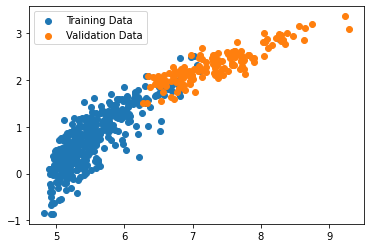

In [38]:
plt.scatter(tf.math.log(p_list_loss_3[0][0][1]), tf.math.log(p_list_loss_3[1][0][1]), linewidths= 1, label = 'Training Data')
plt.scatter(tf.math.log(p_list_loss_3[0][1][1]), tf.math.log(p_list_loss_3[1][1][1]), linewidths= 1, label = 'Validation Data')
plt.legend()
plt.savefig('pm3t')

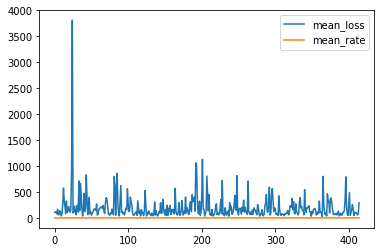

In [41]:
plt.plot(p_list_loss_3[0][0][1]-100, label = 'mean_loss')
plt.plot(p_list_loss_3[1][0][1]/10, label = 'mean_rate')
plt.legend()
plt.savefig('pm3ttr')

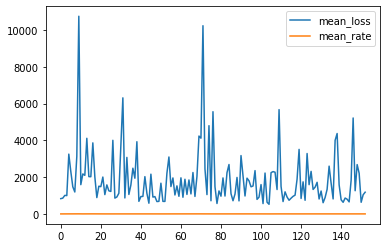

In [42]:
plt.plot((p_list_loss_3[0][1][1]-6), label = 'mean_loss')
plt.plot((p_list_loss_3[1][1][1]-13)/5, label = 'mean_rate')
plt.legend()
plt.savefig('pm3tva')

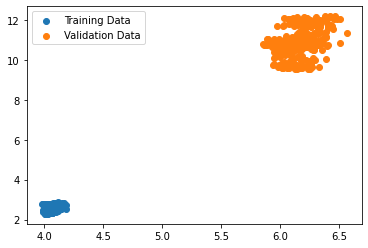

In [30]:
plt.scatter(cmod_list_loss_3[0][0][0], cmod_list_loss_3[1][0][0], label = 'Training Data')
plt.scatter(cmod_list_loss_3[0][1][0], cmod_list_loss_3[1][1][0], label = 'Validation Data')
plt.legend()
plt.savefig('cm3l')

In [34]:
cmod_list_loss_2 = mod_to_loss(comp_model_2)

InternalError: Exception encountered when calling layer "lstm_3" (type LSTM).

Graph execution error:

Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 19, 128, 1, 14, 130725, 128] 
	 [[{{node CudnnRNN}}]]
	 [[PartitionedCall]] [Op:__inference_lstm_3_layer_call_and_return_conditional_losses_739038]

Call arguments received by layer "lstm_3" (type LSTM):
  • args=('tf.Tensor(shape=(130725, 14, 19), dtype=float32)',)
  • kwargs={'training': 'False'}

In [25]:
tf.random.set_seed(14)
n_rows, n_cols = 3, 3
sample = train_pred.shuffle(10000).take(n_rows * n_cols)

## Model Plots

In [132]:
def modlist_to_plt(modlist, sample, string, modelist):
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    
    for n, (model, mode) in enumerate(zip(modlist, modelist)):
        row = n // (n_cols)
        col = (n % n_cols)
        dat, true = sample
        pred_2 = model(dat)
        pred_1 = [None for x in range(14)] + list(pred_2.mean()[0, ..., 0].numpy())
        true_1 = list(tf.math.reduce_sum(dat[0, ...], axis = -1).numpy()) + list(true[0, ..., 0].numpy())
        if mode == 'comp':
            coun = pred_2.parameters['total_count'][0, ..., 0].numpy()
            probs = pred_2.parameters['probs'][0, ..., 0].numpy()
            ppfl = [None for x in range(14)] + list(nbinom.ppf(0.05, coun, np.ones(1)-probs))
            ppfu = [None for x in range(14)] + list(nbinom.ppf(0.95, coun, np.ones(1)-probs))
        elif mode == 'nb':
            coun = pred_2.parameters['total_count'][0, ..., 0].numpy()
            logits = pred_2.parameters['logits'][0, ..., 0].numpy()
            ppfl = [None for x in range(14)] + list(nbinom.ppf(0.05, coun, np.ones(1)-expit(logits)))
            ppfu = [None for x in range(14)] + list(nbinom.ppf(0.95, coun, np.ones(1)-expit(logits)))
        elif mode == 'p':
            means = pred_2.mean()[0, ..., 0].numpy()
            lambd = np.exp(pred_2.distribution.parameters['log_rate'][0, ..., 0].numpy())
            ppfl = [None for x in range(14)] + list(poisson.ppf(0.05, lambd))
            ppfu = [None for x in range(14)] + list(poisson.ppf(0.95, lambd))
        elif not (mode in ['p', 'nb', 'comp']):
            print('wrong mode')

        axes[row, col].plot(pred_1, label='mean')
        axes[row, col].plot(true_1, label='observed')
        axes[row, col].plot(ppfl, label='5 Percentile')
        axes[row, col].plot(ppfu, label='95 Percentile')
        axes[row, col].set_ylabel("Case counts (People)")
        axes[row, col].set_xlabel(mode + str(col))
    fig.legend(ax.get_legend_handles_labels()[1])
    fig.suptitle("Observed Counts of Cases per Day with Predictions")
    path = string
    plt.savefig(path)

In [134]:
sample1 = train_pred.shuffle(100000).take(1)
for samp in sample1:
    sample1 = samp

In [135]:
sample1_val = val_pred.shuffle(100000).take(1)
for samp in sample1_val:
    sample1_val = samp

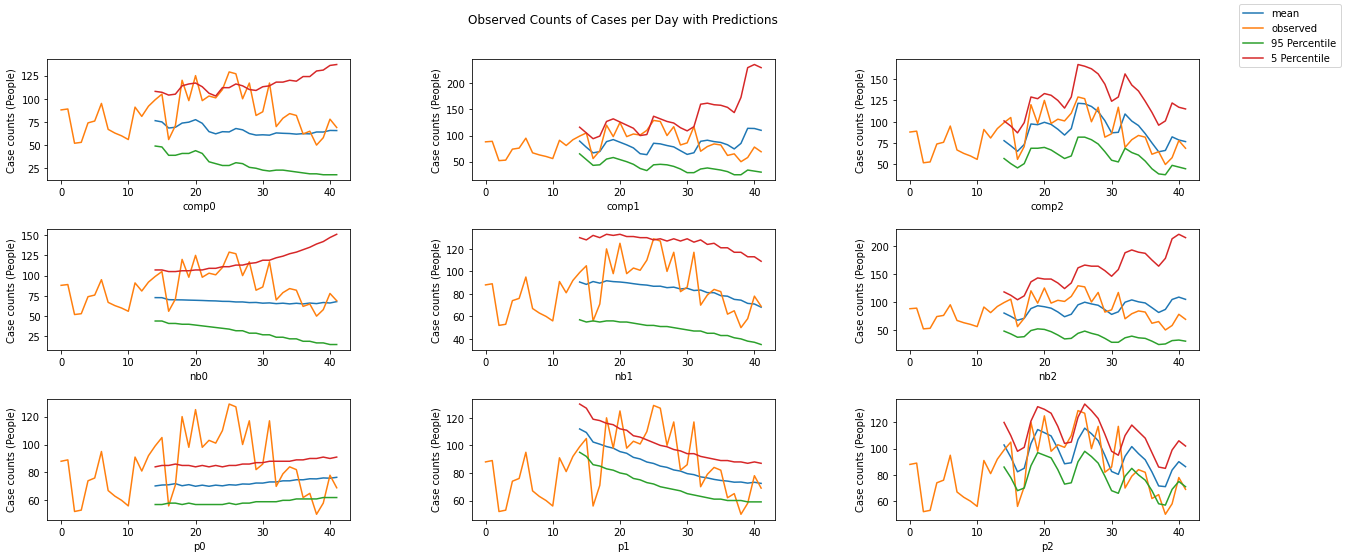

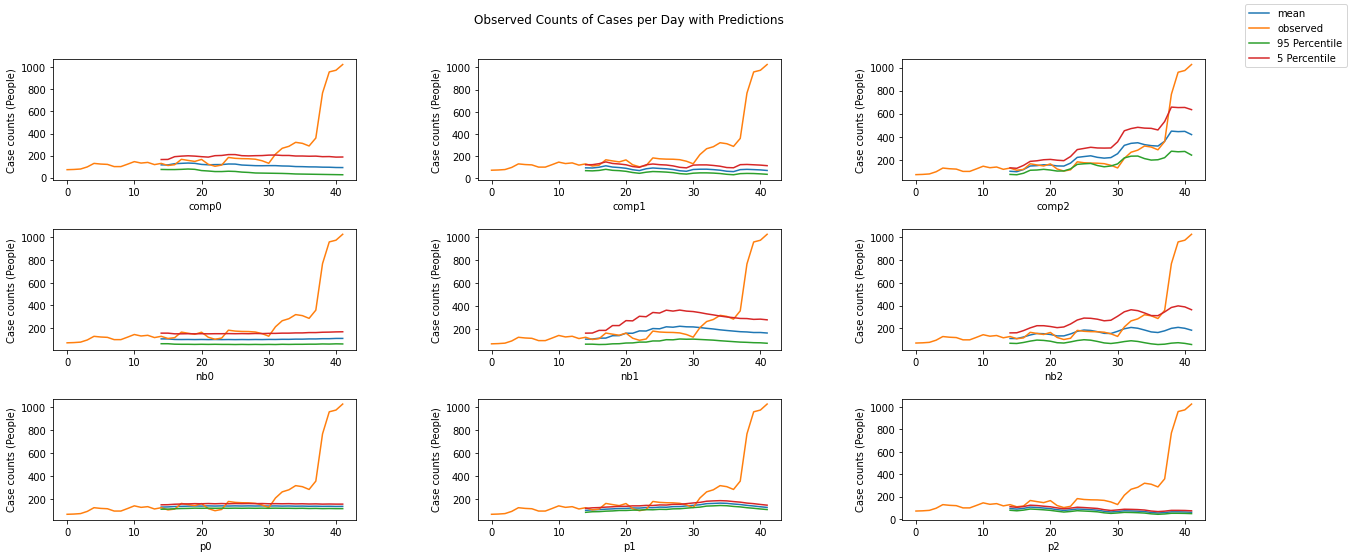

In [136]:
modlist_to_plt(modlist, sample1, 'modstr1', modelist)

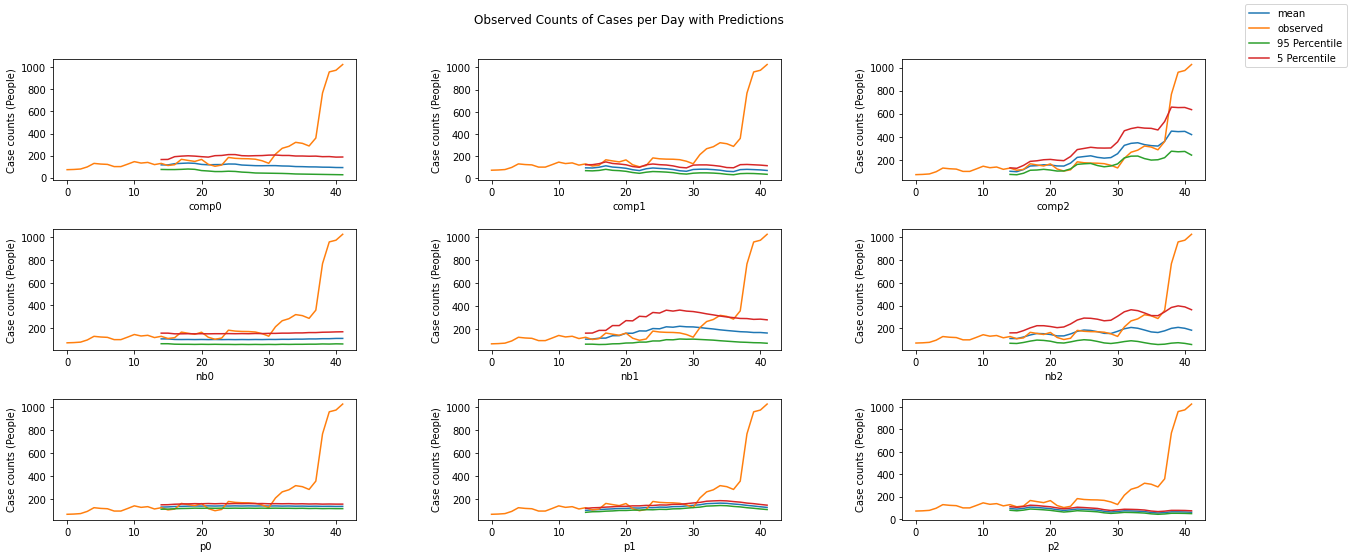

In [137]:
modlist_to_plt(modlist, sample1_val, 'modsva1', modelist)

In [89]:
def mod_to_plt(model, sample, string, mode):
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    for n, samp in enumerate(sample):
        row = n // (n_cols)
        col = (n % n_cols)
        dat, true = samp
        pred_2 = model(dat)
        pred_1 = [None for x in range(14)] + list(pred_2.mean()[0, ..., 0].numpy())
        true_1 = list(tf.math.reduce_sum(dat[0, ...], axis = -1).numpy()) + list(true[0, ..., 0].numpy())
        if mode == 'comp':
            coun = pred_2.parameters['total_count'][0, ..., 0].numpy()
            probs = pred_2.parameters['probs'][0, ..., 0].numpy()
            ppfl = [None for x in range(14)] + list(nbinom.ppf(0.05, coun, np.ones(1)-probs))
            ppfu = [None for x in range(14)] + list(nbinom.ppf(0.95, coun, np.ones(1)-probs))
        elif mode == 'nb':
            coun = pred_2.parameters['total_count'][0, ..., 0].numpy()
            logits = pred_2.parameters['logits'][0, ..., 0].numpy()
            ppfl = [None for x in range(14)] + list(nbinom.ppf(0.05, coun, np.ones(1)-expit(logits)))
            ppfu = [None for x in range(14)] + list(nbinom.ppf(0.95, coun, np.ones(1)-expit(logits)))
        elif mode == 'p':
            means = pred_2.mean()[0, ..., 0].numpy()
            lambd = np.exp(pred_2.distribution.parameters['log_rate'][0, ..., 0].numpy())
            ppfl = [None for x in range(14)] + list(poisson.ppf(0.05, lambd))
            ppfu = [None for x in range(14)] + list(poisson.ppf(0.95, lambd))
        elif not (mode in ['p', 'nb', 'comp']):
            print('wrong mode')

        axes[row, col].plot(pred_1, label='mean')
        axes[row, col].plot(true_1, label='observed')
        axes[row, col].plot(ppfl, label='5 Percentile')
        axes[row, col].plot(ppfu, label='95 Percentile')
        axes[row, col].set_ylabel("Case counts (People)")
        axes[row, col].set_xlabel("Case counts (People)")
    fig.legend(ax.get_legend_handles_labels()[1])
    fig.suptitle("Observed Counts of Cases per Day with Predictions")
    path = string
    plt.savefig(path)

In [71]:
print([sum(x,[]) for x in zip(ax.get_legend_handles_labels())])

[[<matplotlib.lines.Line2D object at 0x7fabbc582c40>, <matplotlib.lines.Line2D object at 0x7fabbc59b2e0>, <matplotlib.lines.Line2D object at 0x7fabbc59bac0>, <matplotlib.lines.Line2D object at 0x7fabbc59beb0>], ['prediction', 'true', 'upper', 'lower']]


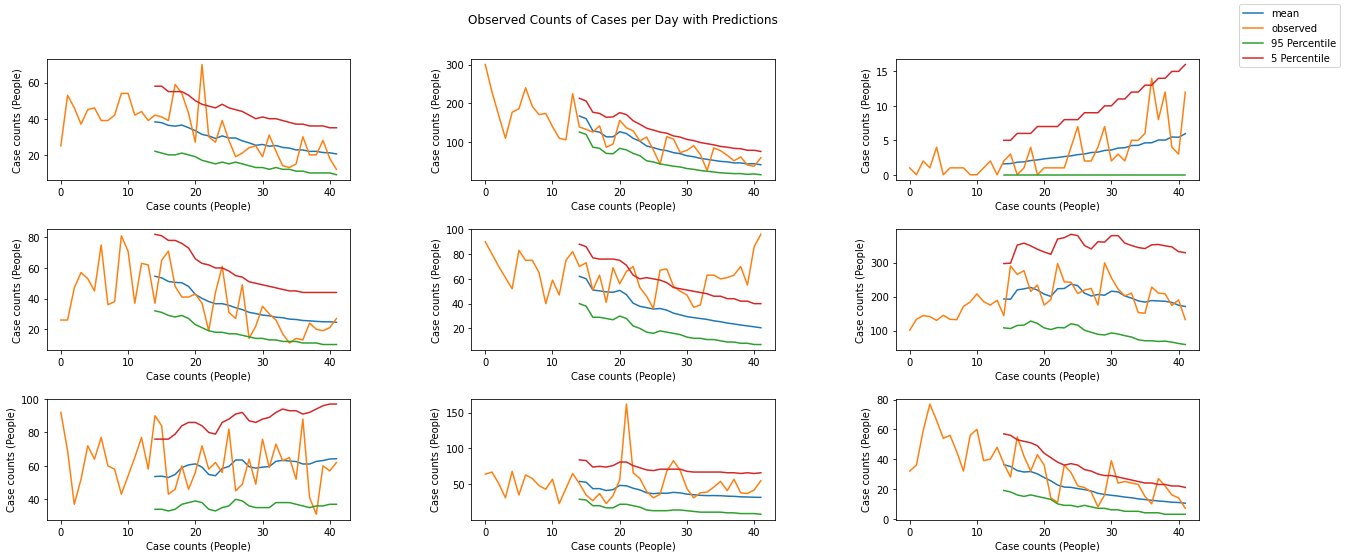

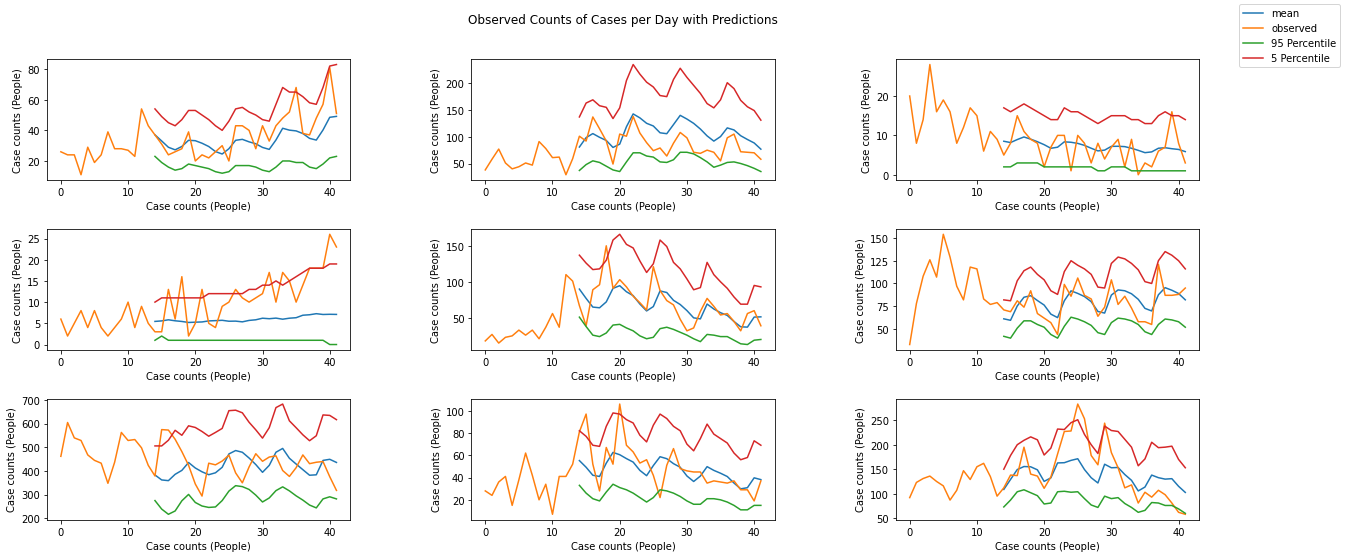

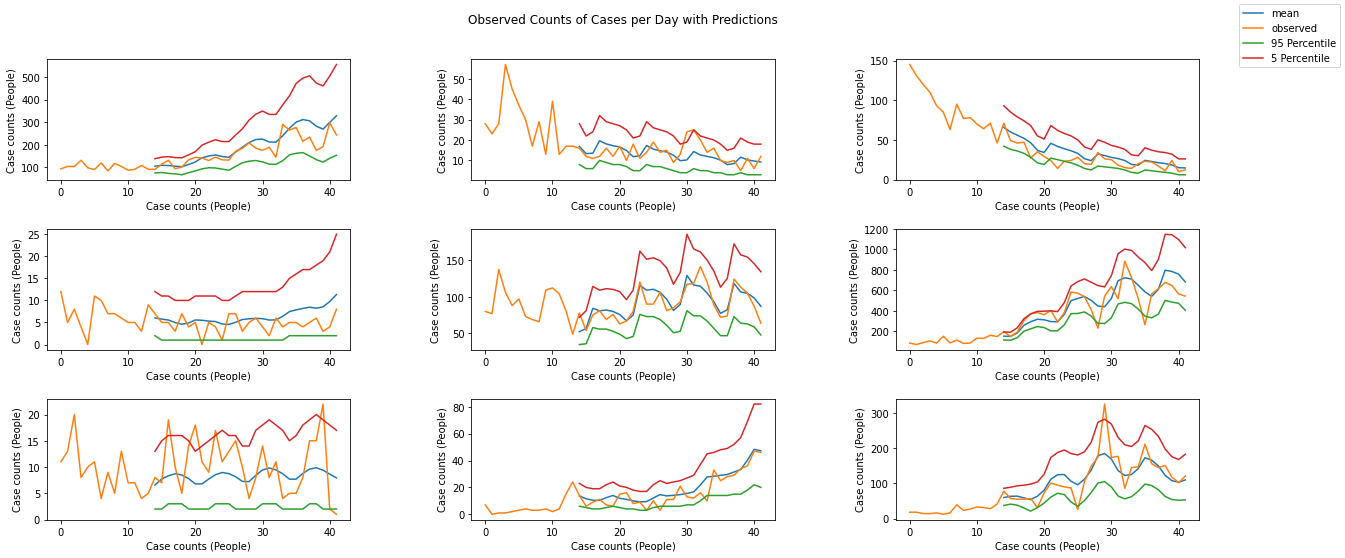

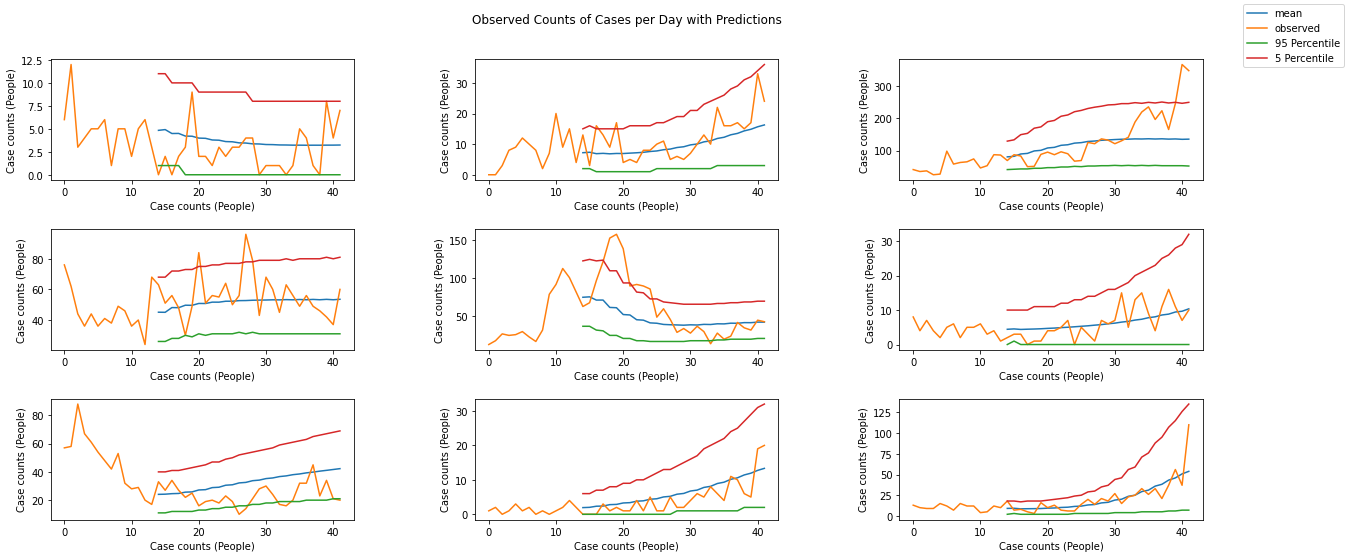

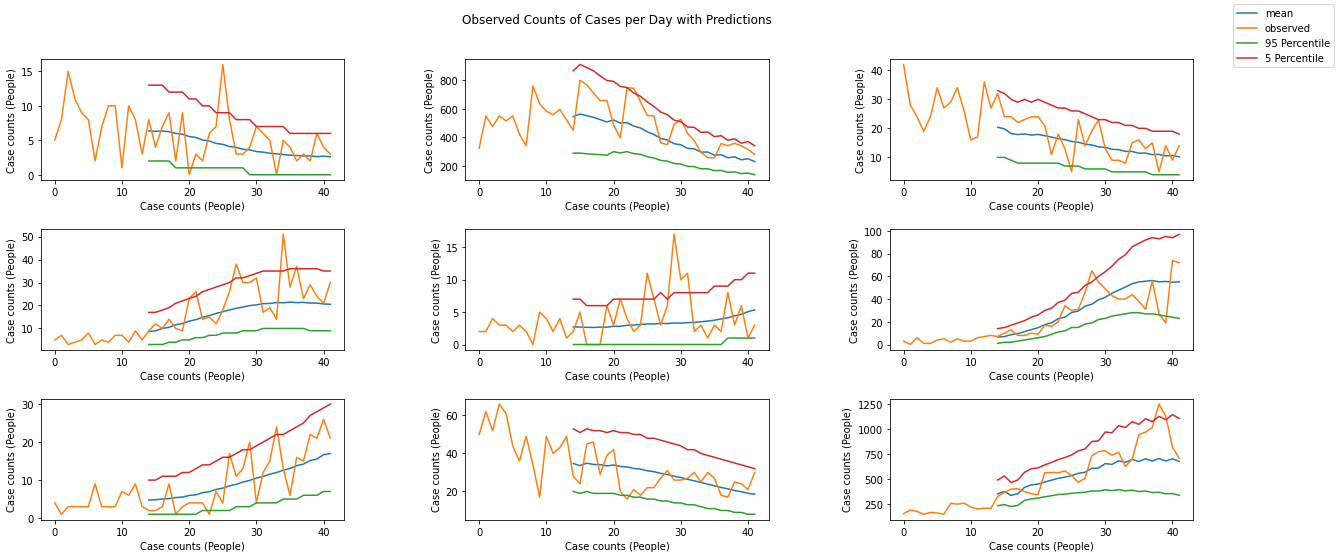

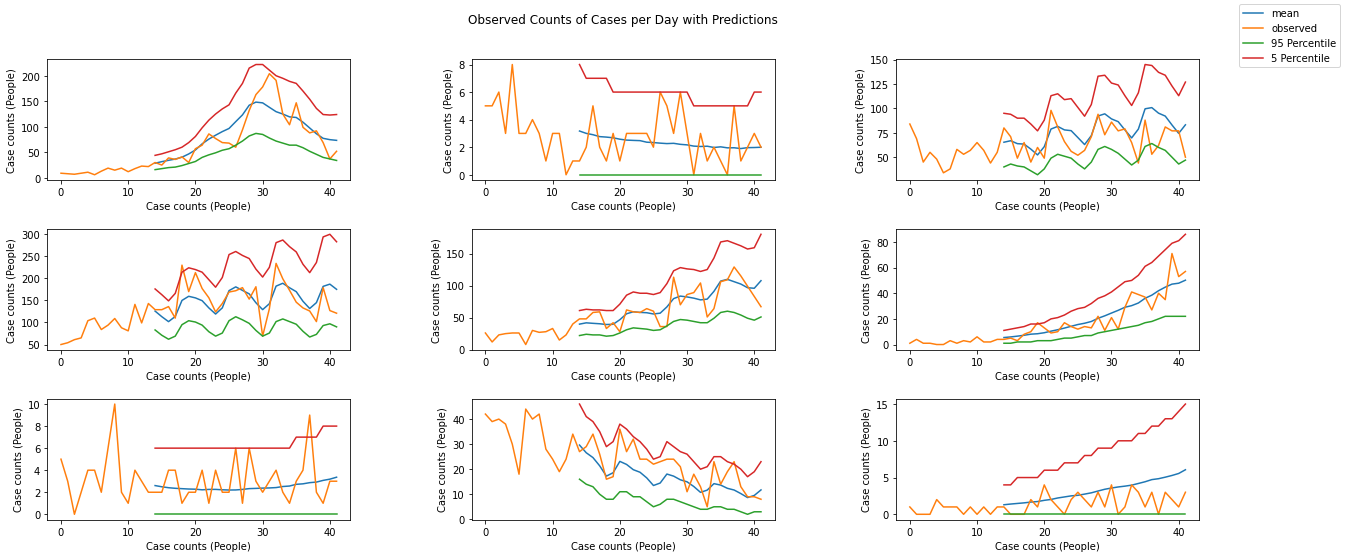

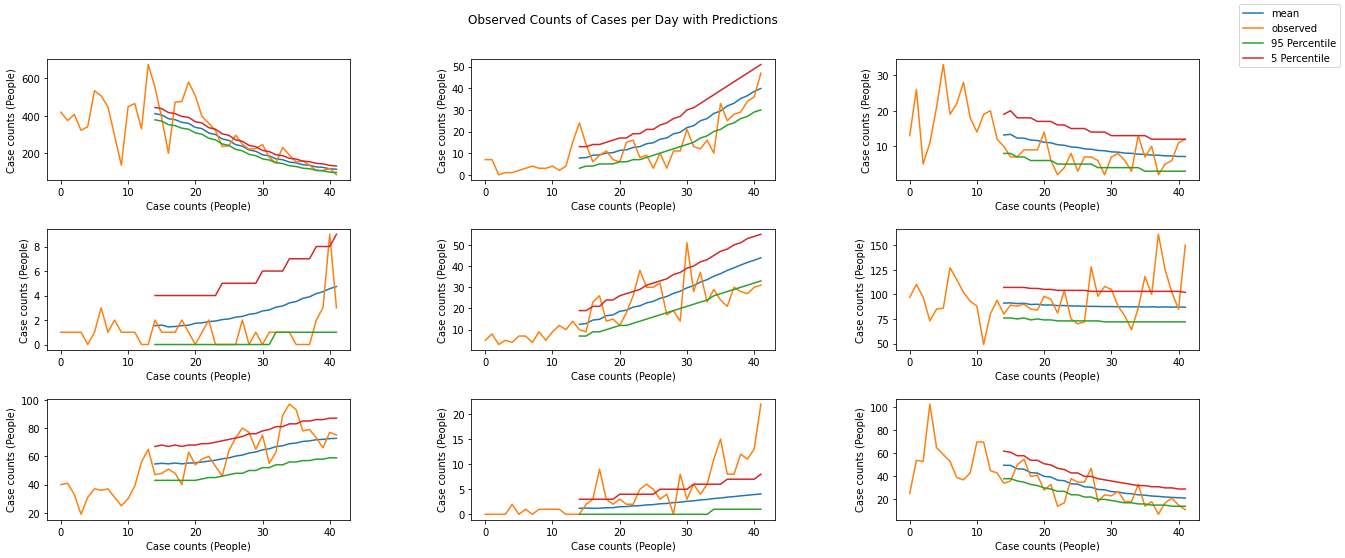

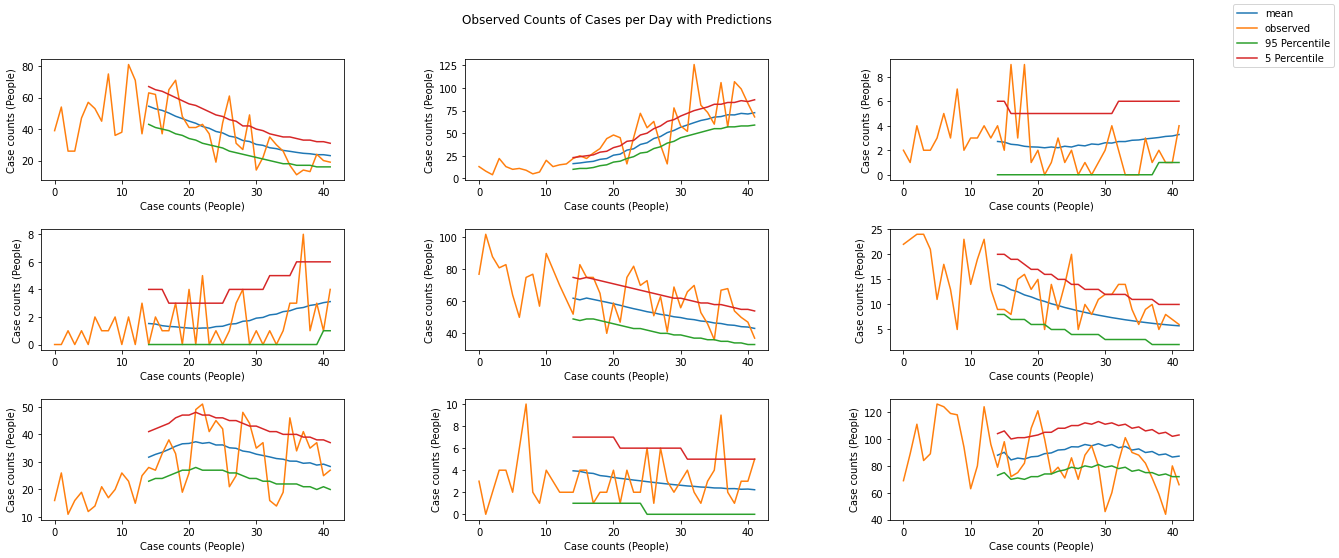

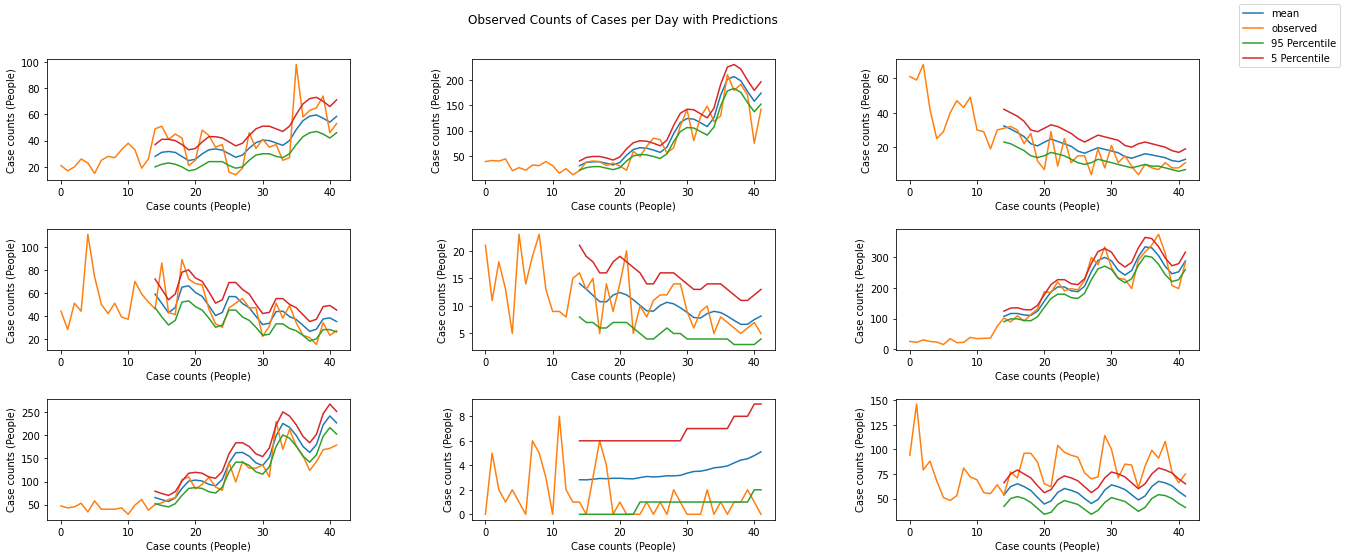

In [90]:
mod_to_plt(comp_model_1, sample, 'modctr1.pdf', 'comp')
mod_to_plt(comp_model_2, sample, 'modctr2.pdf', 'comp')
mod_to_plt(comp_model_3, sample, 'modctr3.pdf', 'comp')
mod_to_plt(nb_model_1, sample, 'modntr1.pdf','nb')
mod_to_plt(nb_model_2, sample, 'modntr2.pdf','nb')
mod_to_plt(nb_model_3, sample, 'modntr3.pdf','nb')
mod_to_plt(p_model_1, sample, 'modptr1.pdf','p')
mod_to_plt(p_model_2, sample, 'modptr2.pdf','p')
mod_to_plt(p_model_3, sample, 'modptr3.pdf','p')


In [45]:
tf.random.set_seed(14)
n_rows, n_cols = 3, 3
sample_val = val_pred.shuffle(100000).take(n_rows * n_cols)

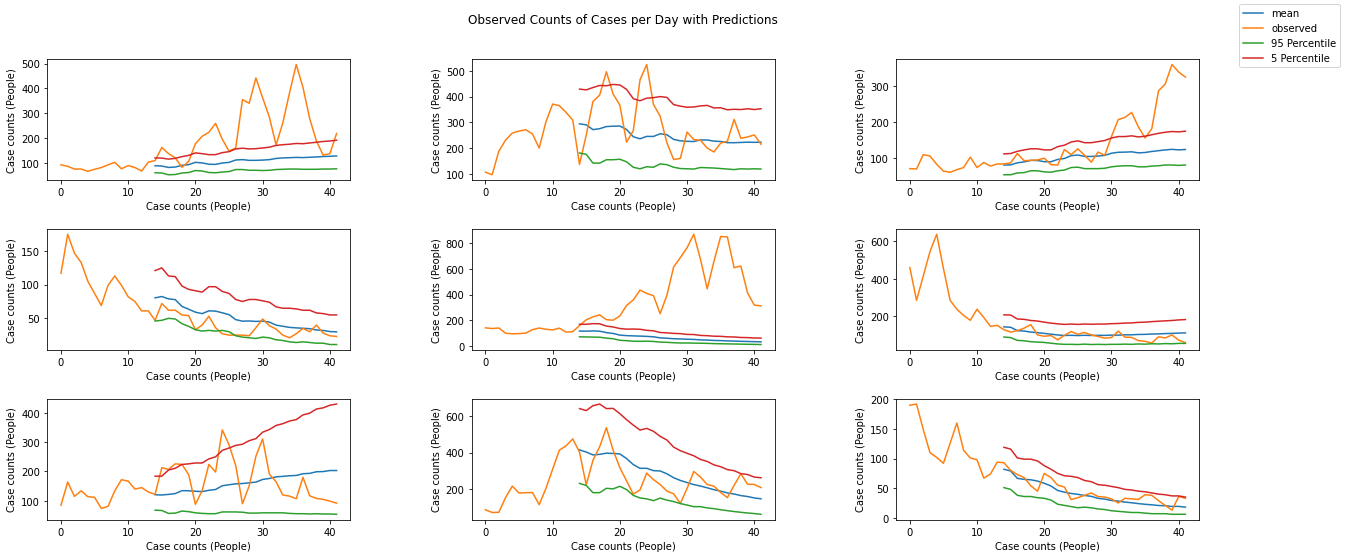

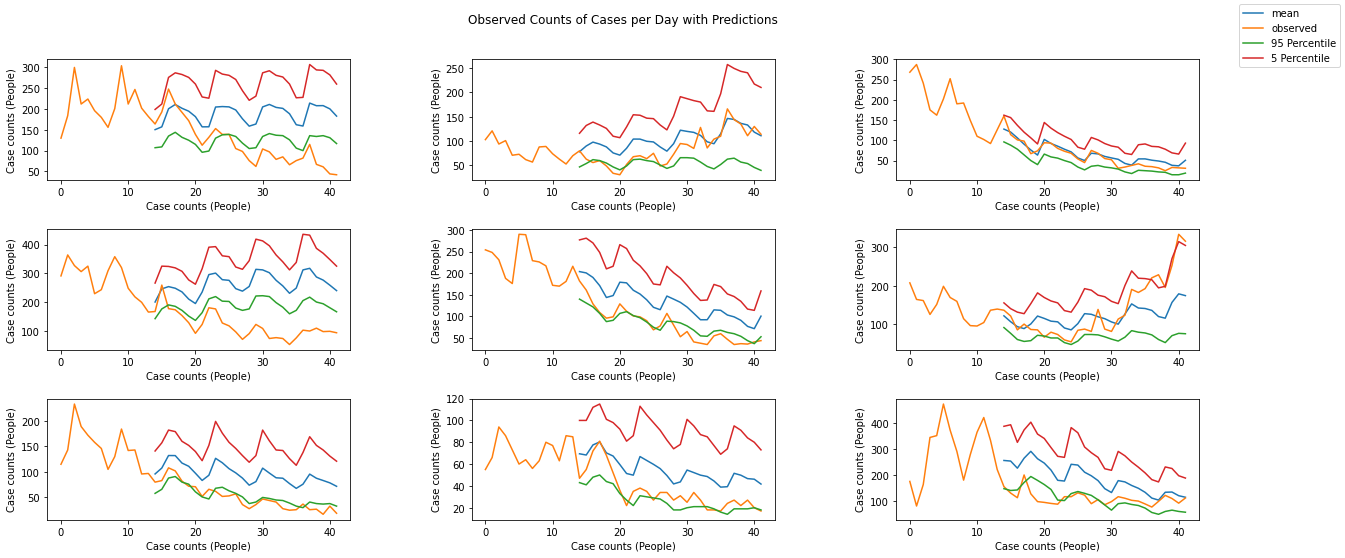

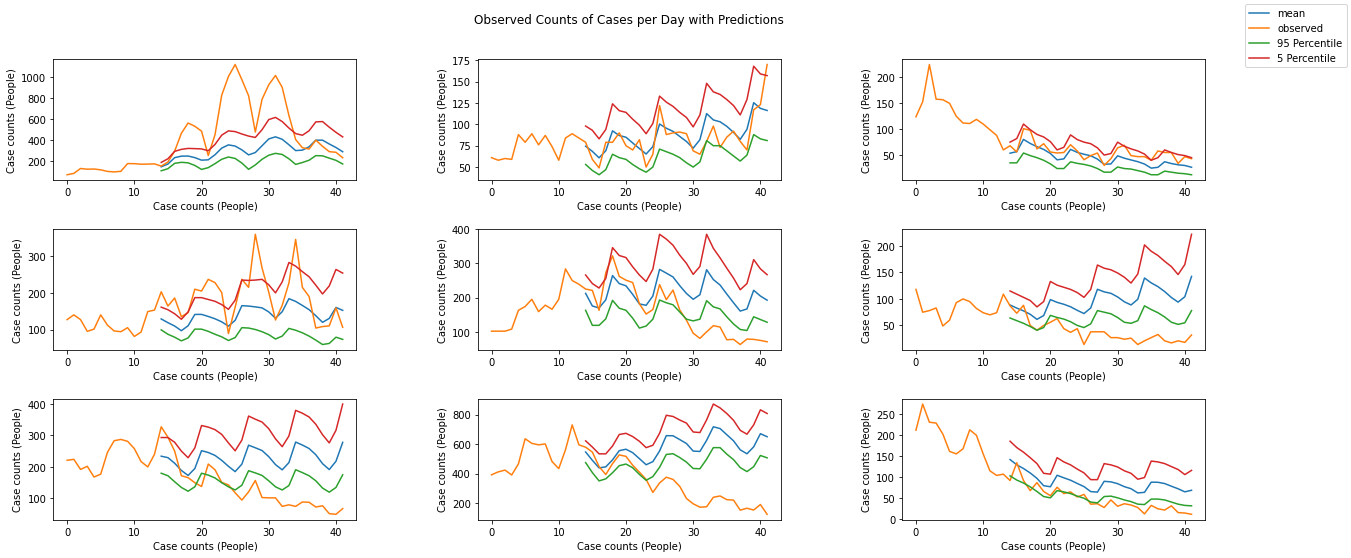

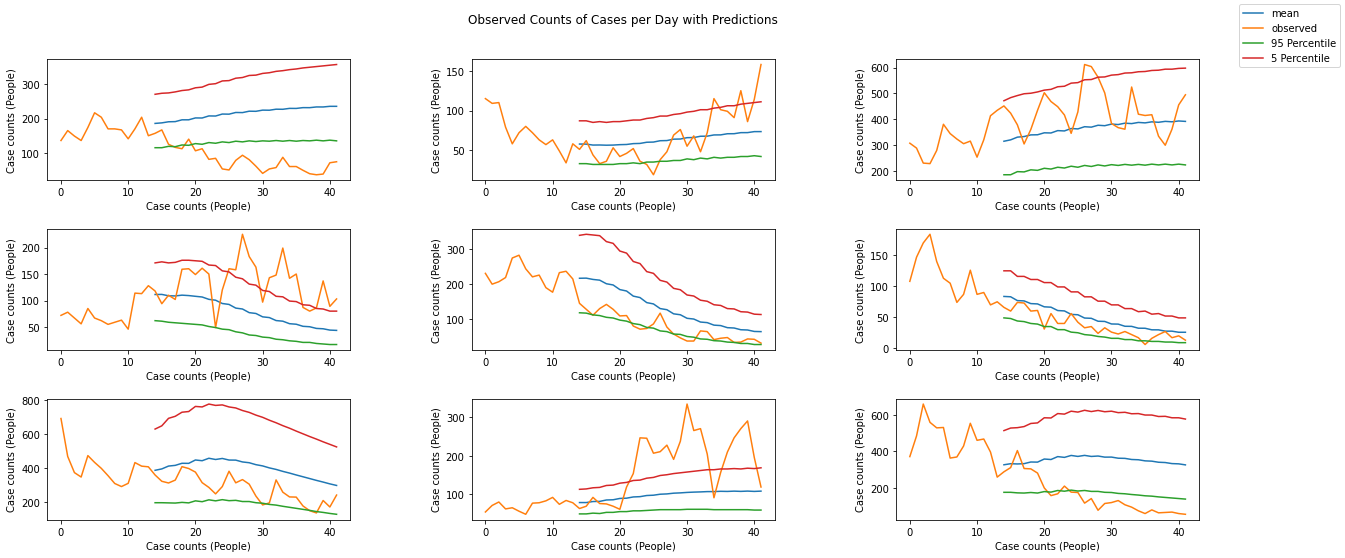

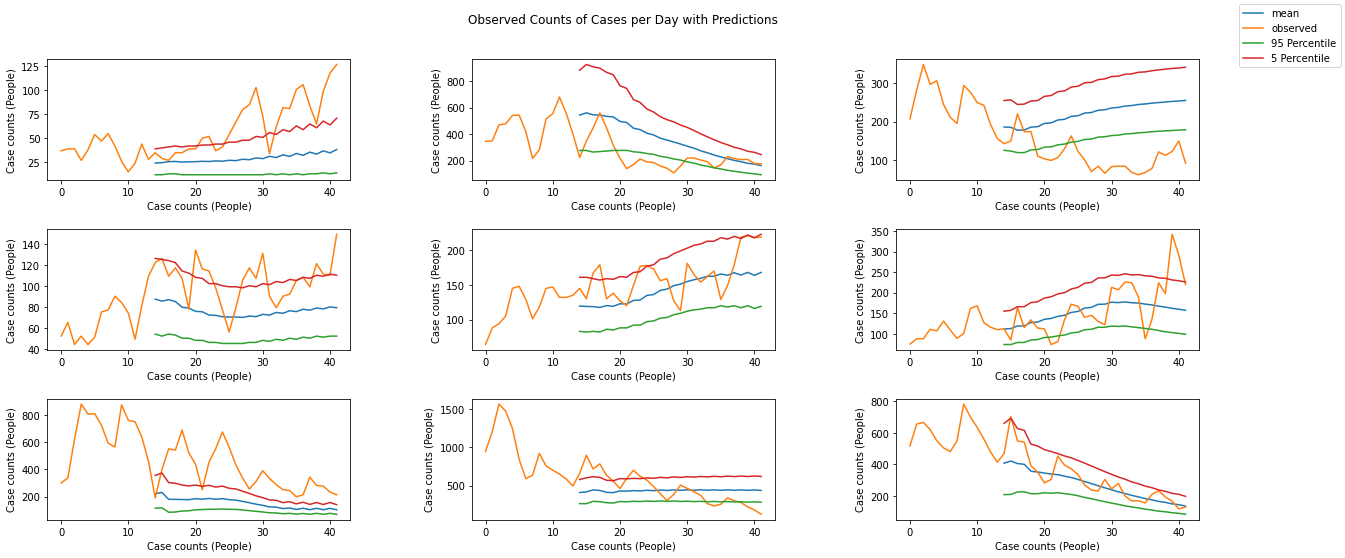

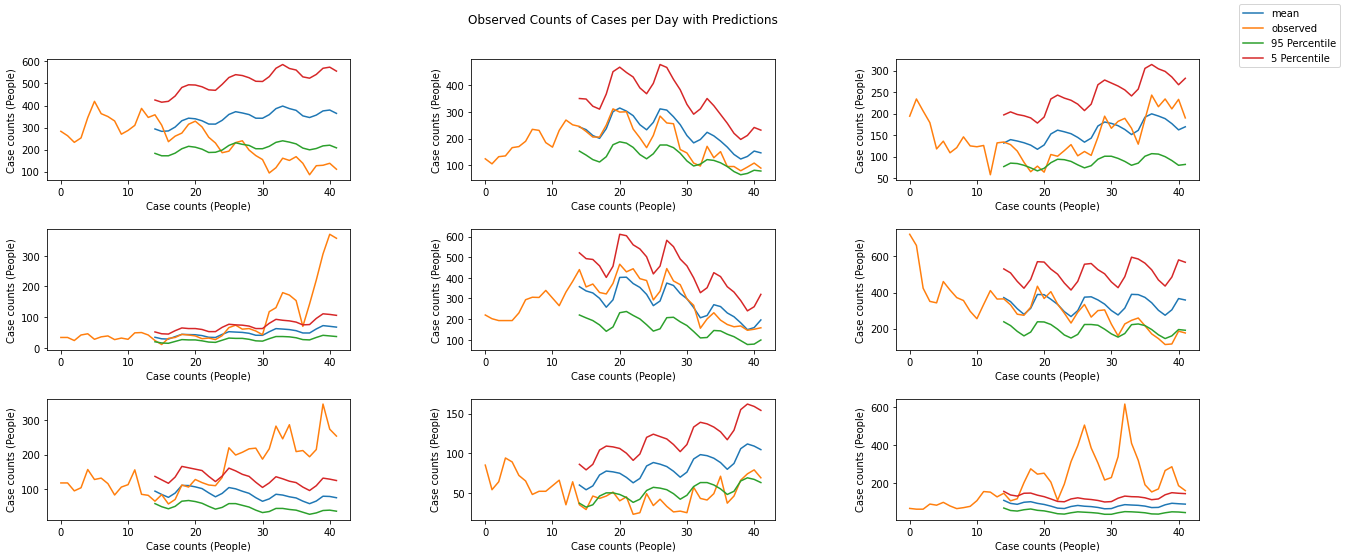

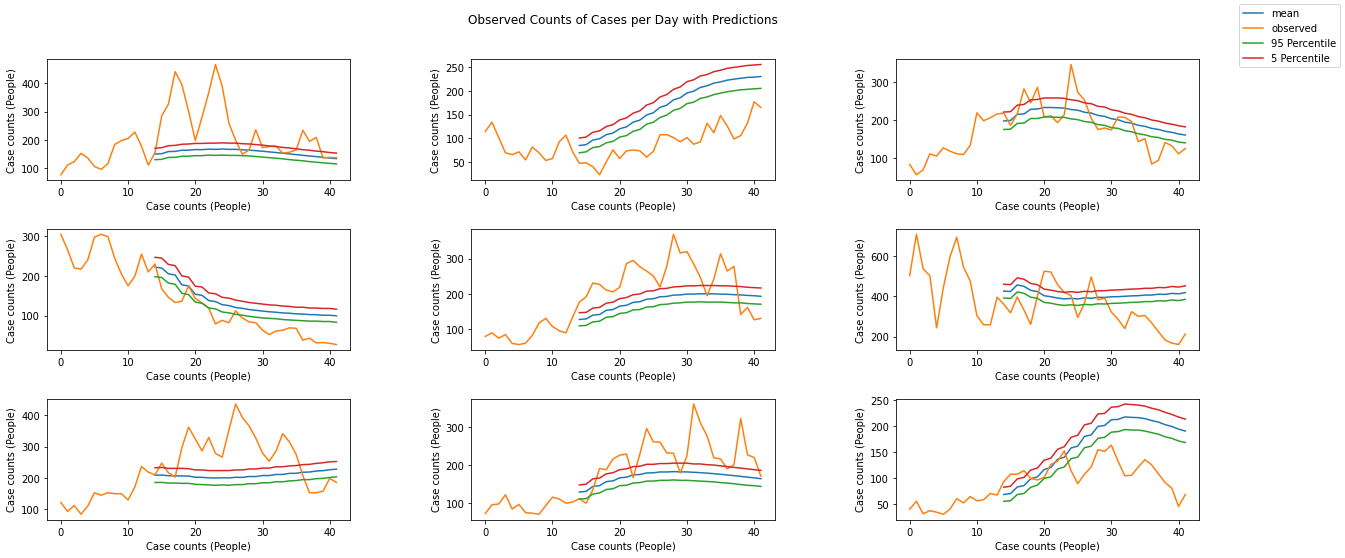

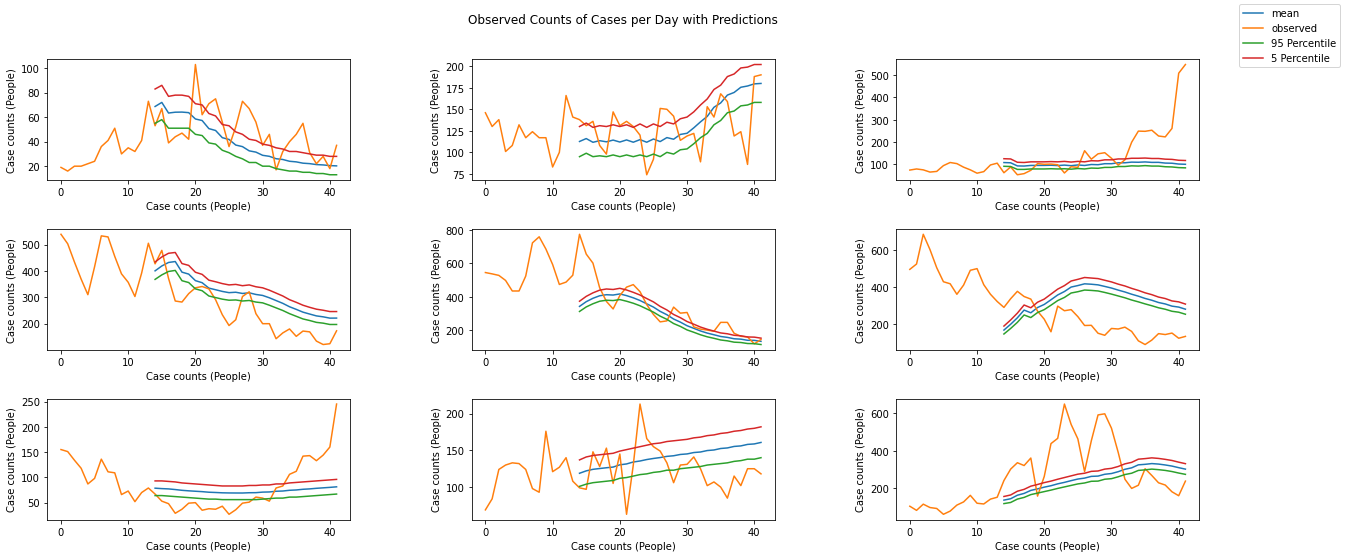

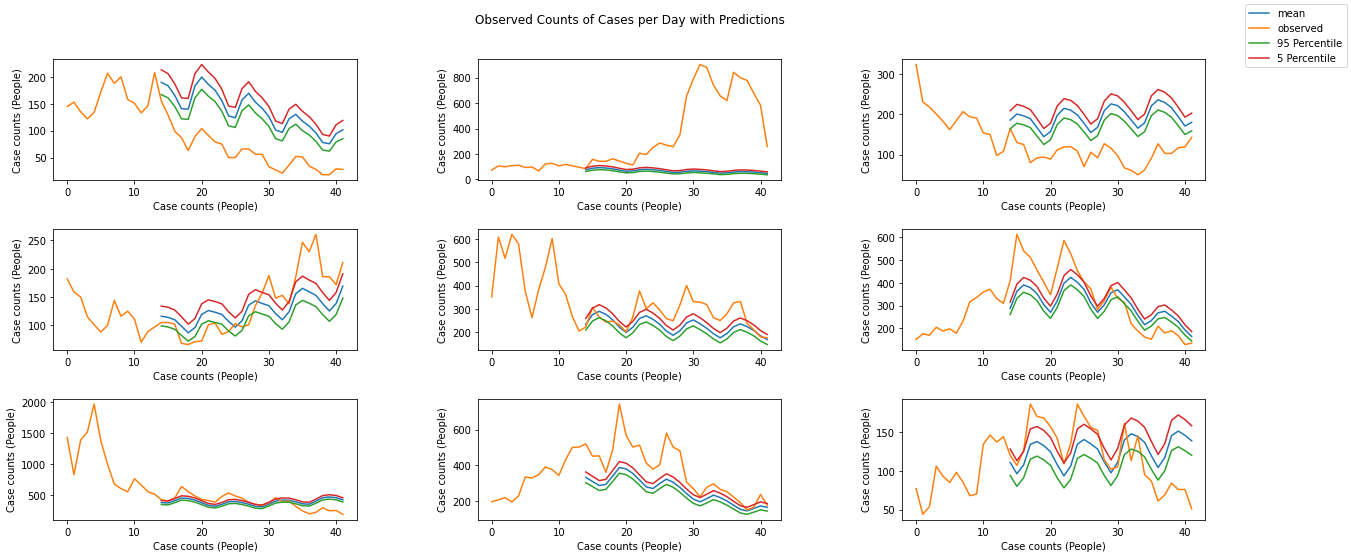

In [91]:
mod_to_plt(comp_model_1, sample_val, 'modcva1.pdf', 'comp')
mod_to_plt(comp_model_2, sample_val, 'modcva2.pdf', 'comp')
mod_to_plt(comp_model_3, sample_val, 'modcva3.pdf', 'comp')
mod_to_plt(nb_model_1, sample_val, 'modnva1.pdf','nb')
mod_to_plt(nb_model_2, sample_val, 'modnva2.pdf','nb')
mod_to_plt(nb_model_3, sample_val, 'modnva3.pdf','nb')
mod_to_plt(p_model_1, sample_val, 'modpva1.pdf','p')
mod_to_plt(p_model_2, sample_val, 'modpva2.pdf','p')
mod_to_plt(p_model_3, sample_val, 'modpva3.pdf','p')


## Epoch Plots

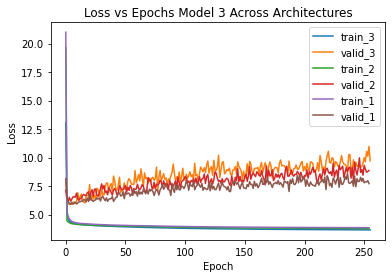

In [53]:
plt.plot(cmod3_hist.history['loss'], label='train_3')
plt.plot(cmod3_hist.history['val_loss'], label='valid_3')
plt.plot(cmod2_hist.history['loss'], label='train_2')
plt.plot(cmod2_hist.history['val_loss'], label='valid_2')
plt.plot(cmod1_hist.history['loss'], label='train_1')
plt.plot(cmod1_hist.history['val_loss'], label='valid_1')
plt.title("Loss vs Epochs Model 3 Across Architectures")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig('mod3le1.pdf')

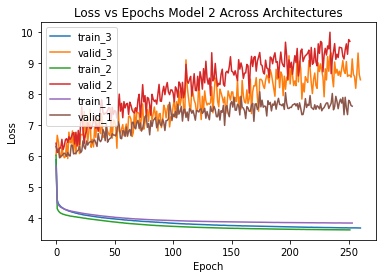

In [54]:
plt.plot(nmod3_hist.history['loss'], label='train_3')
plt.plot(nmod3_hist.history['val_loss'], label='valid_3')
plt.plot(nmod2_hist.history['loss'], label='train_2')
plt.plot(nmod2_hist.history['val_loss'], label='valid_2')
plt.plot(nmod1_hist.history['loss'], label='train_1')
plt.plot(nmod1_hist.history['val_loss'], label='valid_1')
plt.title("Loss vs Epochs Model 2 Across Architectures")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig('mod2le1.pdf')

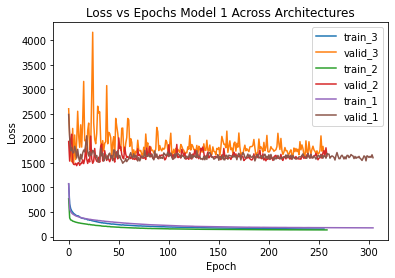

In [55]:
plt.plot(pmod3_hist.history['loss'], label='train_3')
plt.plot(pmod3_hist.history['val_loss'], label='valid_3')
plt.plot(pmod2_hist.history['loss'], label='train_2')
plt.plot(pmod2_hist.history['val_loss'], label='valid_2')
plt.plot(pmod1_hist.history['loss'], label='train_1')
plt.plot(pmod1_hist.history['val_loss'], label='valid_1')
plt.title("Loss vs Epochs Model 1 Across Architectures")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig('mod1le1.pdf')

## Gradient Plots

In [43]:
# for i, (batchx, batchy) in enumerate(train_ds_2.take(1)):
#     y_true = batchy
#     y_pred, r, s, p = comp_model_2(batchx)
#     rec = reconstruction_loss(batchy, y_pred)
#     acc = accuracy90(batchy, y_pred)
#     print(rec)
#     print(rec[0, :,:])
# print(y_pred[62, :,:])
# print(y_true[62, :,:])
#     print(acc)

In [74]:
for i in batch:
    print(batch)

<TakeDataset element_spec=(TensorSpec(shape=(None, 14, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 1), dtype=tf.float32, name=None))>


In [81]:
batch.list_files()

TypeError: list_files() missing 1 required positional argument: 'file_pattern'

In [9]:
y_pred = comp_model_3(sampx)
y_true = samp2
reconstruction_loss(y_true, y_pred)


NameError: name 'sampx' is not defined

In [22]:
sampx[..., -1, :]

<tf.Tensor: shape=(1, 19), dtype=float32, numpy=
array([[ 1.,  4., 25., 13.,  1.,  4.,  1.,  6.,  3.,  4.,  6.,  4.,  2.,
         0.,  0.,  1.,  0.,  0.,  1.]], dtype=float32)>

In [20]:
sampx[..., -1]

<tf.Tensor: shape=(1, 14), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
      dtype=float32)>

In [11]:
tf.math.reduce_sum(sampx[,-1,...], axis=-1, keepdims=False)

SyntaxError: invalid syntax (<ipython-input-11-f422a57e53a0>, line 1)

In [45]:
def gradmap(index):
    with tf.GradientTape(persistent = True) as tape:
        tape.watch(sampx)
        preds = comp_model_5(sampx).mean()
        preds = tf.squeeze(preds)
        pred6 = preds[index]
    grads6 = tf.math.abs(tf.squeeze(tape.gradient(pred6, sampx)))
    #     grads = [tf.squeeze(tape.gradient(pred, sampx)) for pred in preds]
    del tape
    return(grads6)

In [51]:
grads = [gradmap(i) for i in range(7)]
avg = sum(grads)/len(grads)
grads_demean = [x-avg for x in grads] + [avg]

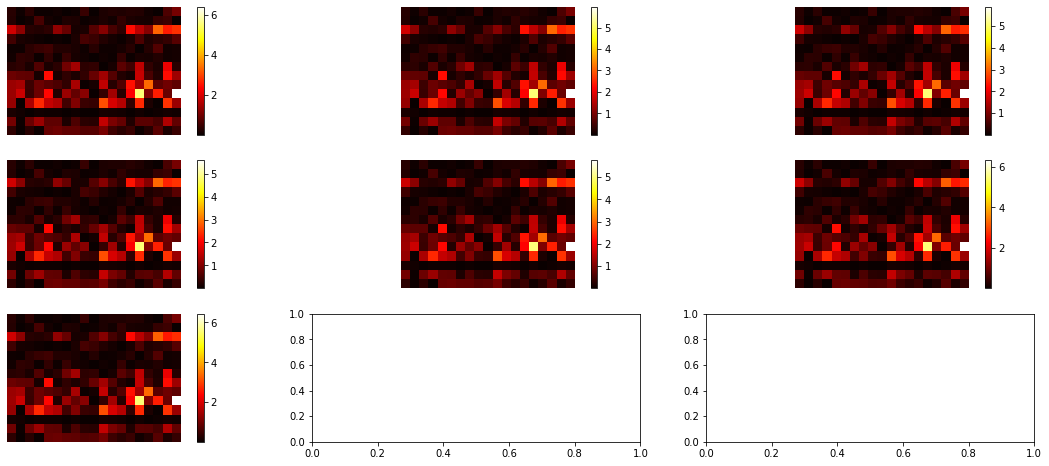

In [52]:
n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))

for n, grad in enumerate(grads):
    row = n // (n_cols)
    col = (n % n_cols)

    im = axes[row, col].imshow(gradmap(n).numpy(), cmap='hot')
    axes[row, col].axis('off')
    plt.colorbar(im, ax = axes[row, col])
    
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

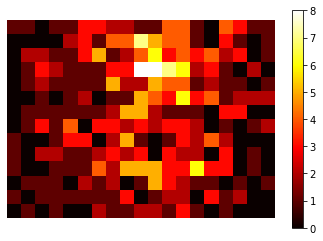

In [32]:
im = plt.imshow(tf.squeeze(dat), cmap='hot')
plt.axis('off')
plt.colorbar(im)
plt.show

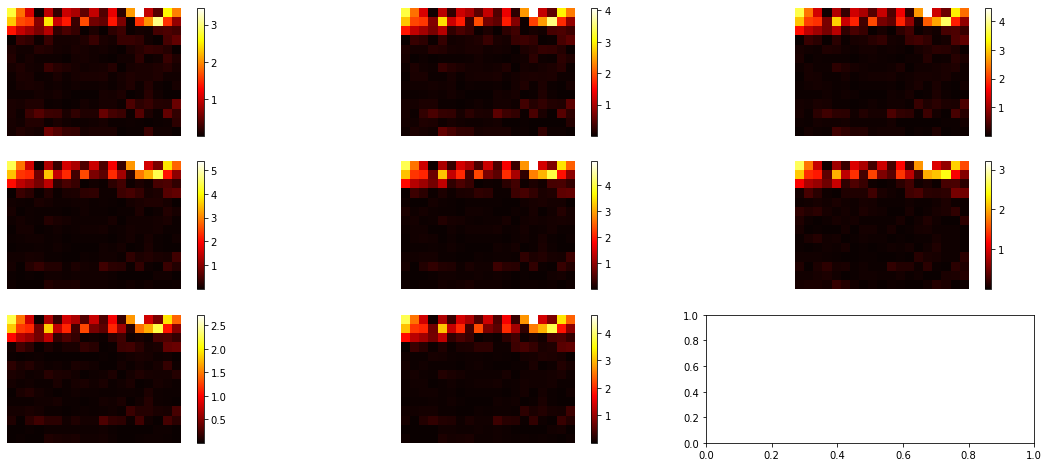

In [49]:
n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))

for n, grad in enumerate(grads_demean):
    row = n // (n_cols)
    col = (n % n_cols)

    im = axes[row, col].imshow(gradmap(n).numpy(), cmap='hot')
    axes[row, col].axis('off')
    plt.colorbar(im, ax = axes[row, col])
    
plt.show()

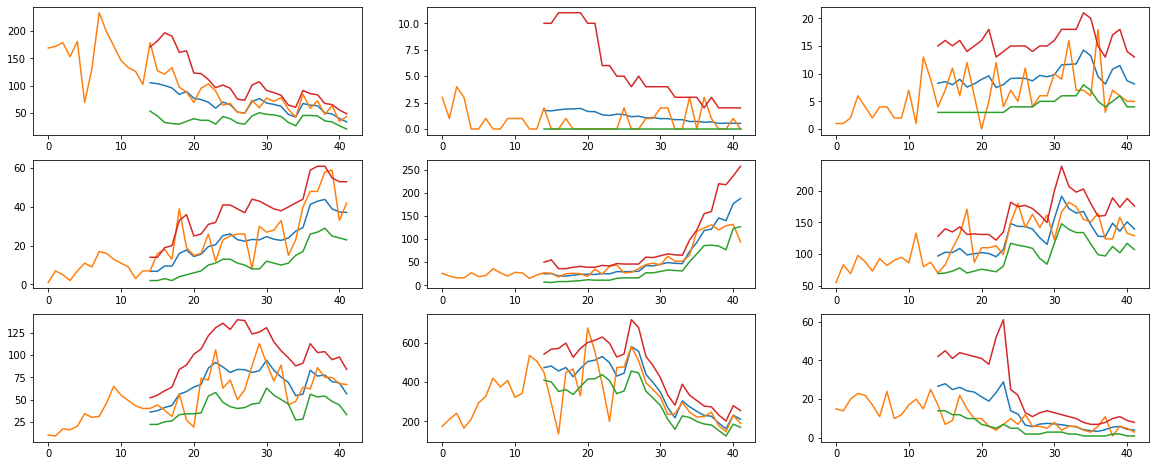

In [42]:
tf.random.set_seed(14)
n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
sample = train_pred.shuffle(10000).take(n_rows * n_cols)
for n, samp in enumerate(sample):
    row = n // (n_cols)
    col = (n % n_cols)
    
    dat, _ , true = samp
    pred_2 = comp_model_3(dat)

    pred_1 = [None for x in range(14)] + list(pred_2.mean()[0, ..., 0].numpy())
    true_1 = list(tf.math.reduce_sum(dat[0, ...], axis = -1).numpy()) + list(true[0, ..., 0].numpy())
    coun = list(pred_2.parameters['total_count'][0, ..., 0].numpy())
    prob = list(pred_2.parameters['probs'][0, ..., 0].numpy())
    ppfl = [None for x in range(14)] + [nbinom.ppf(0.05, coun[i], 1 - prob[i]) for i in range(28)]
    ppfu = [None for x in range(14)] + [nbinom.ppf(0.95, coun[i], 1 - prob[i]) for i in range(28)]

    
    
    axes[row, col].plot(pred_1, label='prediction')
    axes[row, col].plot(true_1, label='true')
    axes[row, col].plot(ppfl, label='upper')
    axes[row, col].plot(ppfu, label='lower')
plt.savefig('mod3tr1.pdf')    

In [21]:

sample = train_pred.shuffle(100).take(1)

for n, samp in enumerate(sample):
    row = n // (n_cols)
    col = 2*(n % n_cols)
    dat, pred, true = samp
    pred_2 = comp_model_3(dat)


NameError: name 'train_pred' is not defined

In [39]:
from scipy.stats import nbinom
from scipy.special import expit



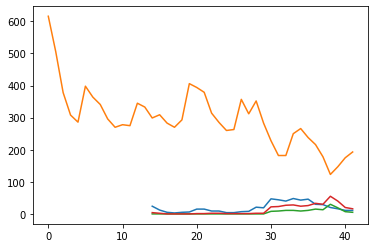

In [47]:
dat, pred, true = samp
pred_2 = comp_model_3(dat)

# pred_1 = [None for x in range(14)] + list(pred_2.mean()[0, ..., 0].numpy())
pred_1 = [None for x in range(14)] + [nbinom.ppf(0.5, coun[i], probs[i]) for i in range(28)]
true_1 = list(tf.math.reduce_sum(dat[0, ...], axis=-1)) + list(true[0, ..., 0])
coun = list(pred_2.parameters['total_count'][0, ..., 0].numpy())
probs = list(pred_2.parameters['probs'][0, ..., 0].numpy())
ppfl = [None for x in range(14)] + [nbinom.ppf(0.05, coun[i], probs[i]) for i in range(28)]
ppfu = [None for x in range(14)] + [nbinom.ppf(0.95, coun[i], probs[i]) for i in range(28)]


plt.plot(pred_1, label='prediction')
plt.plot(true_1, label='true')
plt.plot(ppfl, label='upper')
plt.plot(ppfu, label='lower')

In [51]:
y_pred = pred_2
coun = y_pred.parameters['total_count'].numpy()
prob = y_pred.parameters['probs'].numpy()
ppfl = nbinom.ppf(0.05, coun, 1 - prob)
ppfu = nbinom.ppf(0.95, coun, 1 - prob)

In [62]:
print(np.multiply(ppfu>true.numpy(), ppfl<true.numpy()))

[[[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [False]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]]]


In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
def make_fn_plt(model, sample, savestr):
    for n, samp in enumerate(sample):
        row = n // (n_cols)
        col = (n % n_cols)

        dat, _ , true = samp
        pred_2 = comp_model_3(dat)

        pred_1 = [None for x in range(14)] + list(pred_2.mean()[0, ..., 0].numpy())
        true_1 = list(tf.math.reduce_sum(dat[0, ...], axis = -1).numpy()) + list(true[0, ..., 0].numpy())
        coun = list(pred_2.parameters['total_count'][0, ..., 0].numpy())
        prob = list(pred_2.parameters['probs'][0, ..., 0].numpy())
        ppfl = [None for x in range(14)] + [nbinom.ppf(0.05, coun[i], 1 - prob[i]) for i in range(28)]
        ppfu = [None for x in range(14)] + [nbinom.ppf(0.95, coun[i], 1 - prob[i]) for i in range(28)]



        axes[row, col].plot(pred_1, label='prediction')
        axes[row, col].plot(true_1, label='true')
        axes[row, col].plot(ppfl, label='upper')
        axes[row, col].plot(ppfu, label='lower')
        
    plt.savefig(savestr)

In [25]:
comp_model_2.save('~/comp_model_2/fol')
# comp_model_2.save('~/comp_model_2')

OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.